In [19]:
##Borrar datos del entorno
rm(list=ls())


#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr,googledrive,janitor,survey,
               showtext,sf, httr,jsonlite)
#Fuente para los gráficos
font_add_google("Montserrat", "pop")
showtext_auto()

## Funciones

In [20]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))%>%
    arrange(año)
  return(df)
}

In [21]:
crea_mapa <- function(df, custom_palette, titulo,geodataframe) {
  library(tidyverse)
  library(sf)


datos_planos<-df%>%
#Crear periodos
mutate(periodo=case_when(año>=2013 & año<=2018~"2013-2018",
                        año>=2019 & año<=2023~"2019-2023"))%>%
group_by(periodo,estado)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
ungroup()%>%
#Crear distribución porcentual
group_by(periodo)%>%
mutate(porcentaje=round(acciones/sum(acciones)*100,2))%>%
ungroup()%>%
#Crear cortes para la distribución
mutate(acciones_cat=cut(porcentaje,breaks=5, dig.lab=2))%>%
 #Formato de etiquetas
  mutate(
    etiquetas = if_else(
      str_detect(acciones_cat, "^\\([-]"), 
      str_replace(as.character(acciones_cat), "^\\(\\-", "("), 
      as.character(acciones_cat) 
    ),
  #Guión en lugar de coma
  etiquetas = str_replace(etiquetas, ",", "-"),
  etiquetas = str_replace(etiquetas, "\\]$", ")") 
)%>%
#Unir con geodataframe
left_join(geodataframe, by = c("estado" = "state_name"))

geodata<-datos_planos%>%
st_as_sf()

#Crear mapa
  ggplot() +
  # Capa con datos de los municipios
  geom_sf(data=geodata,aes(fill = etiquetas),
          colour = "#ffffff", size = 0.07) +
  # Agrega título, subtítulo y fuente
  labs(title = titulo,
       subtitle="(Porcentaje)",
       caption = "
Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).") +
  scale_fill_manual("%",values = custom_palette)+
  guides(fill = guide_legend(reverse = TRUE)) +
    theme_void()+
  theme(plot.title = element_text(hjust = 0, size=25,face="bold"),
        plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
        plot.caption = element_text(hjust = 0,size=15),
        legend.position="right",
        #Fuente y tamaño
        text=element_text("pop",
                          size=20))+
    facet_wrap(~periodo)

}

In [22]:
paleta<-rev(c("#691c32ff", "#901d3dff","#ac2540ff","#c88f80ff","#e3c8a6ff"))


## Cartografía para generar los mapas

In [23]:
estados<-st_read("https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson")%>%
  #Renombrar Distrito Federal como Ciudad de México
mutate(state_name=case_when(state_name=="Distrito Federal" ~ "Ciudad de México",
TRUE ~ state_name))

Reading layer `states' from data source 
  `https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.4 ymin: 14.5321 xmax: -86.72404 ymax: 32.71865
Geodetic CRS:  WGS 84


## Subsidios

In [24]:
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado"

In [25]:
df<-consulta_api(url)%>%
  #Filtrar por organismo
  filter(organismo=="CONAVI")

### Mapa

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


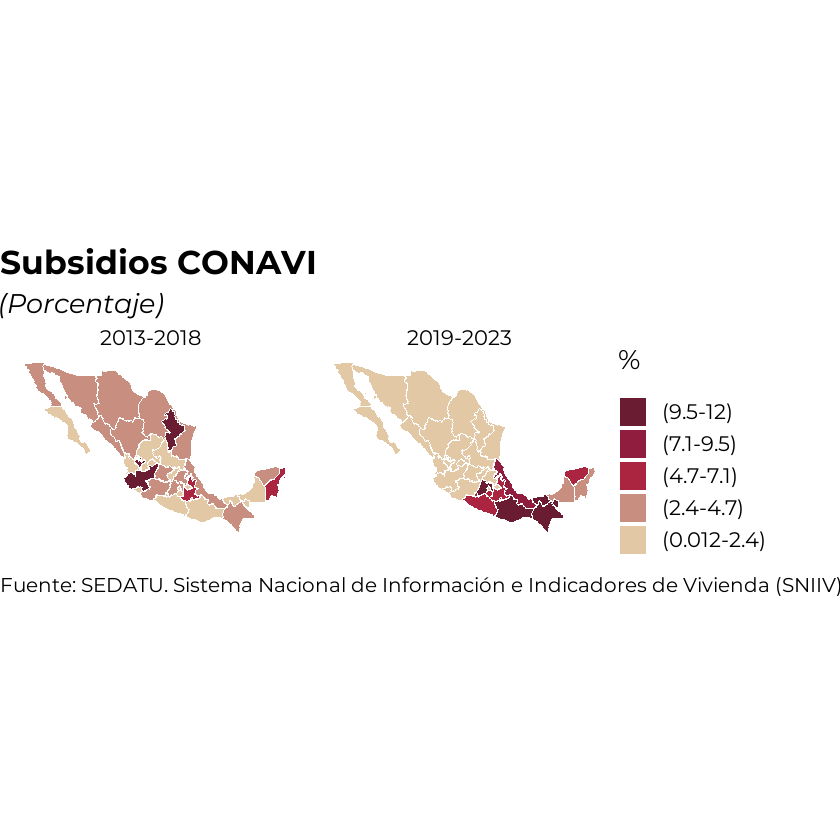

In [26]:
#Crear mapa
crea_mapa(df, paleta, "Subsidios CONAVI",estados)

## Financiamientos

In [27]:
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado"

In [28]:
df<-consulta_api(url)%>%
  #Filtrar por organismo
  filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="SHF (FONDEO)")

### Mapa

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


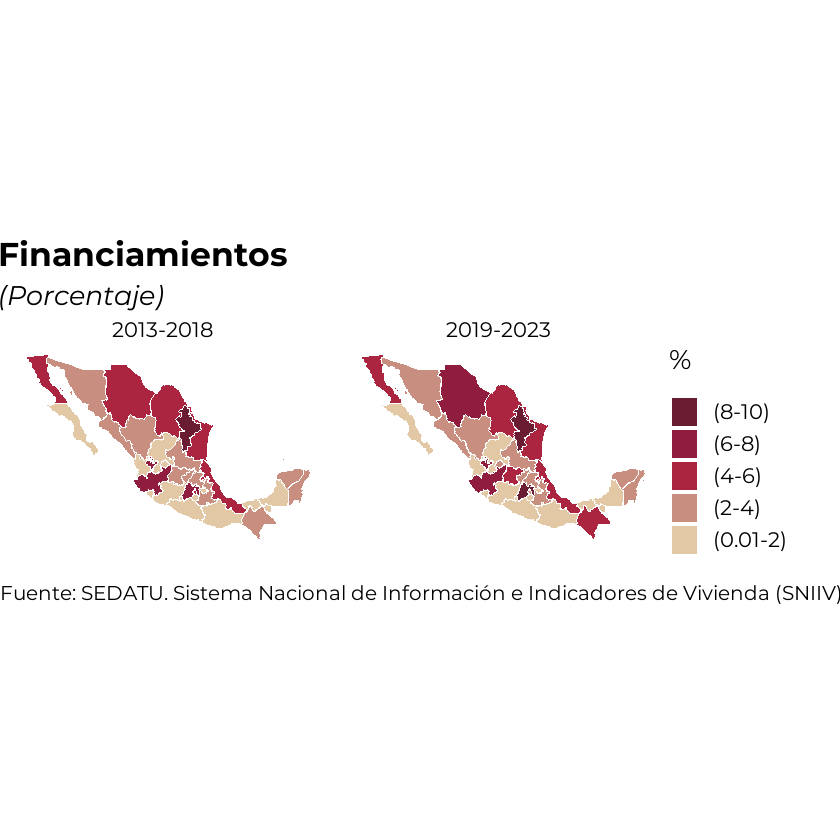

In [29]:
crea_mapa(df, paleta, "Financiamientos",estados)

## Acciones

In [30]:
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado,tipo_credito"

In [31]:
df<-consulta_api(url)%>%
  #Filtrar por organismo
  filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="SHF (FONDEO)")%>%
  #Filtrar por tipo de crédito
  filter(tipo_credito=="Credito individual")

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


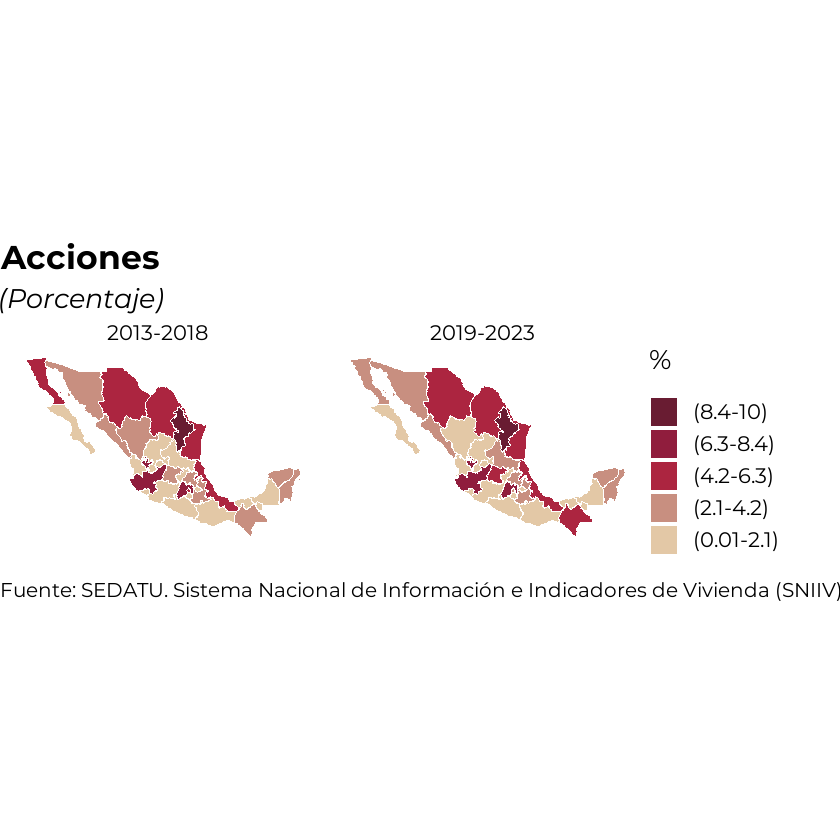

In [32]:
crea_mapa(df, paleta, "Acciones",estados)